Based on modeling done in "new_stats_modeling.ipynb", I am making some changes to the features in my model.  These are summarized in that notebook, and the new baseball savant page is in the below:

https://baseballsavant.mlb.com/leaderboard/custom?year=2020,2019,2018,2017,2016,2015&type=batter&filter=&sort=16&sortDir=desc&min=200&selections=player_age,b_total_pa,b_bb_percent,b_game,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,solidcontact_percent,flareburner_percent,poorlyunder_percent,poorlytopped_percent,poorlyweak_percent,z_swing_percent,oz_swing_percent,iz_contact_percent,whiff_percent,pull_percent,straightaway_percent,opposite_percent,f_strike_percent,sprint_speed,&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm

Import needed packages:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from IPython.core.display import display, HTML    # make sure Jupyter knows to display it as HTML
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import unicodedata
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Changing directory to use the code:

In [3]:
pwd

'/Users/patrickbovard/Documents/GitHub/Metis_Project_2'

In [4]:
cd Webscraping_code

/Users/patrickbovard/Documents/GitHub/Metis_Project_2/Webscraping_code


Importing the functions I need to build the new dataframe:

In [5]:
from baseball_savant_code import *
from fangraphs_wrc_code import *

## BELOW CHANGED TO MARKDOWN AFTER PICKLE:

Add in the urls:

savant_url = 'https://baseballsavant.mlb.com/leaderboard/custom?year=2020,2019,2018,2017,2016,2015&type=batter&filter=&sort=16&sortDir=desc&min=200&selections=player_age,b_total_pa,b_bb_percent,b_game,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,solidcontact_percent,flareburner_percent,poorlyunder_percent,poorlytopped_percent,poorlyweak_percent,z_swing_percent,oz_swing_percent,iz_contact_percent,whiff_percent,pull_percent,straightaway_percent,opposite_percent,f_strike_percent,sprint_speed,&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm'
fg_url = 'https://www.fangraphs.com/leaders/season-stat-grid?position=B&seasonStart=2015&seasonEnd=2020&stat=wRC%2B&pastMinPt=200&curMinPt=0&mode=normal'

Create new dataframes:

savant_df = Savant_DataFrame_Builder(savant_url)

fg_df = wRC_DataFrame_Shifter(fg_url)

savant_df.head()

fg_df.info()

## Merge The DF's
*Note: this code is originally from Project_2_Savant notebook, moving here to clean up the workflow.*

fg_df.rename(columns={'Name-Year':'Player_Year_ID'}, inplace=True)

fg_df.head(2)

Function to strip accent marks from names so they can all be mapped to the savant data:

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

player_list = fg_df.Player_Year_ID.to_list()

updated_names = [strip_accents(name).replace('?','e') for name in player_list]

updated_names

fg_df.Player_Year_ID = updated_names

Back to Baseball Savant:

player_list = savant_df.Player.tolist()

player_list_split = [player.split(', ') for player in player_list]
for player in player_list_split:
    player[0] = player[0].strip()

final_player_list = [(player[1] + ' ' + player[0]) for player in player_list_split]    

print(final_player_list)

year_list = savant_df.Year.tolist()

year_list = [int(year) for year in year_list]
print(year_list)

player_year_id = []
for i, player in enumerate(final_player_list):
    id_str = player + "-" + str(year_list[i])
    player_year_id.append(id_str)
print(player_year_id)

savant_df['Player_Year_ID'] = player_year_id

savant_df.sample(15)

Actual merging:

combined_df = savant_df.merge(fg_df, how='left', on='Player_Year_ID')

combined_df

1893 rows as expected.

## Exploring combined DF:

combined_df.info()

Filling in null values:

combined_df[combined_df['wRC+'].isnull()]

combined_df.iloc[222, 25] = 146 #2018
combined_df.iloc[132, 25] = 104 #2019
combined_df.iloc[521, 25] = 163 #2020
combined_df.iloc[185, 25] = 146 #2017
combined_df.iloc[133, 25] = 72 #2015
combined_df.iloc[230, 25] = 119 #2016

combined_df.info()

Convert needed columns to numeric:

combined_df.drop(columns=['Player Link', 'Player_Year_ID'], inplace=True)

num_col = list(combined_df.columns[1:])

for column in num_col:
    combined_df[column] = combined_df[column].apply(pd.to_numeric, errors='coerce')

combined_df.info()

Checking for values of 0 in wRC+

combined_df[combined_df['wRC+'] < 10]

#Players w/ exactly 200 PA - didn't pull from FanGraphs.
combined_df.iloc[367, 23] = 65 #caratini, 2018
combined_df.iloc[425, 23] = 52 #Elias Diaz, 2017
combined_df.iloc[1046, 23] = 87 #Szczur, 2016
combined_df.iloc[1291, 23] = 61 #Tyler Moore,2015
#Jeff mathis 2019 is correct.

combined_df[combined_df['wRC+'] < 10]

combined_df.describe()

Pickle Dataframe, in case needed later:

combined_df.to_pickle("./stats_round_3.pkl")

## ABOVE CHANGED TO MARKDOWN AFTER PICKLE

Read in Pickle:

In [3]:
combined_df = pd.read_pickle('./stats_round_3.pkl')

In [4]:
combined_df.head()

Player  Year  Age   PA  BB%    G  Avg EV (MPH)  Avg LA (°)  \
0   Astudillo, Willians  2019   28  204  2.5   58          85.9        15.4   
1           Revere, Ben  2015   27  634  5.0  152          83.1         5.0   
2           Holt, Brock  2016   28  324  8.3   94          86.0         6.3   
3        Murphy, Daniel  2015   30  538  5.8  130          89.9        11.9   
4        Iglesias, Jose  2015   25  454  5.5  120          83.8         4.6   

   Barrel%  Solid Contact %  ...  Zone Swing %  Out of Zone Swing %  \
0      2.7              5.4  ...          81.5                 39.7   
1      0.0              2.1  ...          56.8                 28.3   
2      2.5              4.7  ...          54.4                 23.1   
3      4.9              6.2  ...          70.1                 31.5   
4      0.0              1.3  ...          56.8                 32.6   

   In Zone Contact %  Whiff %  Pull %  Straight Away %  Oppo %  \
0               96.8      8.9    39.2             37.1    23.7   
1               96.4     10.7    34.3             41.2    24.4   
2               96.0     11.1    35.2             34.7    30.1   
3               95.9      9.0    37.3             35.1    27.6   
4               95.5     10.0    33.0             38.8    28.2   

   First Strike %  Sprint Speed  wRC+  
0            64.7          24.2    76  
1            56.6          28.4    98  
2            58.6          28.2    87  
3            57.2          25.7   109  
4            63.4          28.4    97  

[5 rows x 24 columns]

In [5]:
combined_df.describe()

Year          Age           PA          BB%            G  \
count  1893.000000  1893.000000  1893.000000  1893.000000  1893.000000   
mean   2017.206022    28.826730   435.196513     8.519863   114.937137   
std       1.557844     3.816009   155.619031     3.169189    32.113398   
min    2015.000000    20.000000   200.000000     1.500000    46.000000   
25%    2016.000000    26.000000   284.000000     6.300000    89.000000   
50%    2017.000000    28.000000   432.000000     8.200000   119.000000   
75%    2019.000000    32.000000   570.000000    10.400000   144.000000   
max    2020.000000    44.000000   747.000000    20.600000   162.000000   

       Avg EV (MPH)   Avg LA (°)      Barrel%  Solid Contact %  \
count   1893.000000  1893.000000  1893.000000      1893.000000   
mean      88.413312    12.229688     6.797834         5.770100   
std        2.215767     4.386683     4.020786         2.023787   
min       80.200000    -1.400000     0.000000         0.000000   
25%       87.000000     9.300000     3.700000         4.400000   
50%       88.500000    12.300000     6.300000         5.800000   
75%       89.900000    15.300000     9.300000         7.200000   
max       96.100000    29.700000    25.700000        18.000000   

       Flare/Burner %  ...  Zone Swing %  Out of Zone Swing %  \
count     1893.000000  ...   1893.000000          1893.000000   
mean        24.733967  ...     66.659641            28.202324   
std          3.418355  ...      5.884461             5.974287   
min         13.700000  ...     47.400000            10.200000   
25%         22.400000  ...     62.800000            24.000000   
50%         24.600000  ...     66.700000            28.100000   
75%         27.100000  ...     70.600000            32.100000   
max         37.500000  ...     83.700000            51.300000   

       In Zone Contact %      Whiff %       Pull %  Straight Away %  \
count        1893.000000  1893.000000  1893.000000      1893.000000   
mean           83.313418    23.935552    37.029900        37.787480   
std             5.529379     6.284289     5.844259         3.847019   
min            62.400000     7.900000    16.700000        25.900000   
25%            79.700000    19.500000    33.400000        35.300000   
50%            83.700000    23.800000    37.000000        37.800000   
75%            87.300000    28.100000    40.900000        40.400000   
max            96.800000    44.700000    56.800000        53.800000   

            Oppo %  First Strike %  Sprint Speed         wRC+  
count  1893.000000     1893.000000   1893.000000  1893.000000  
mean     25.182831       60.317591     27.015742   101.297412  
std       4.225243        3.862401      1.454924    25.640274  
min      13.400000       48.200000     21.900000     2.000000  
25%      22.300000       57.500000     26.100000    84.000000  
50%      25.100000       60.400000     27.100000   101.000000  
75%      27.900000       63.000000     28.100000   118.000000  
max      43.400000       71.800000     30.800000   197.000000  

[8 rows x 23 columns]

## Initial Visualization:

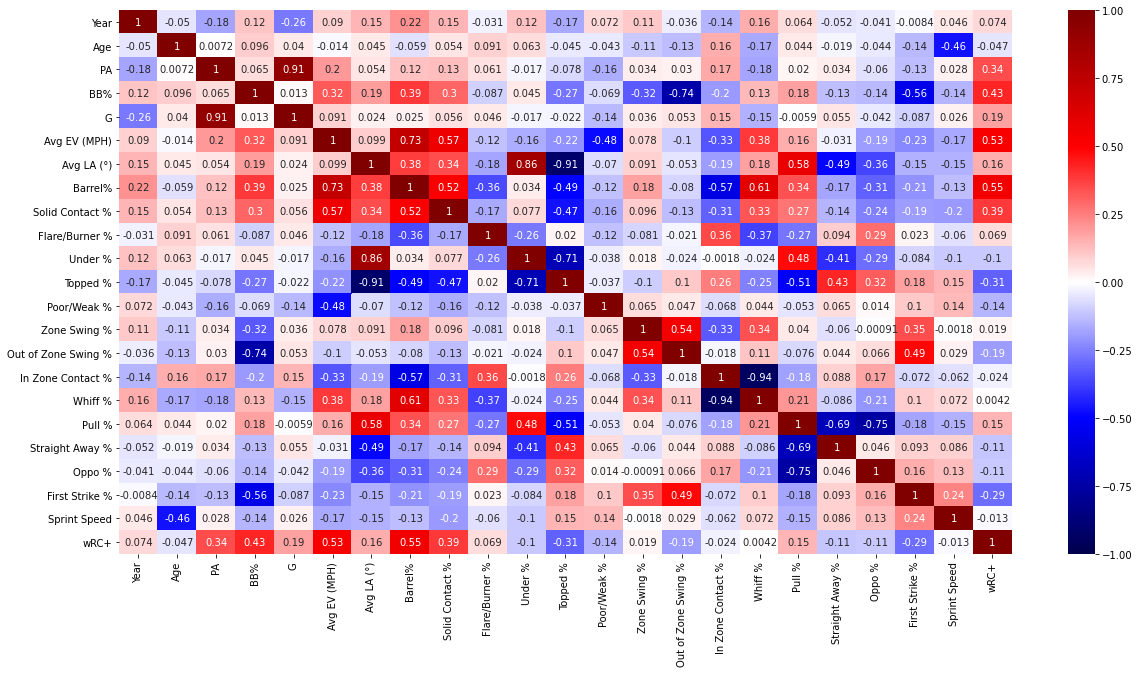

In [6]:
sns.heatmap(combined_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

BB Rate has a pretty strong relationship (relatively) to wRC+.

### Pairplot markdown'ed out to save time in re-running code:

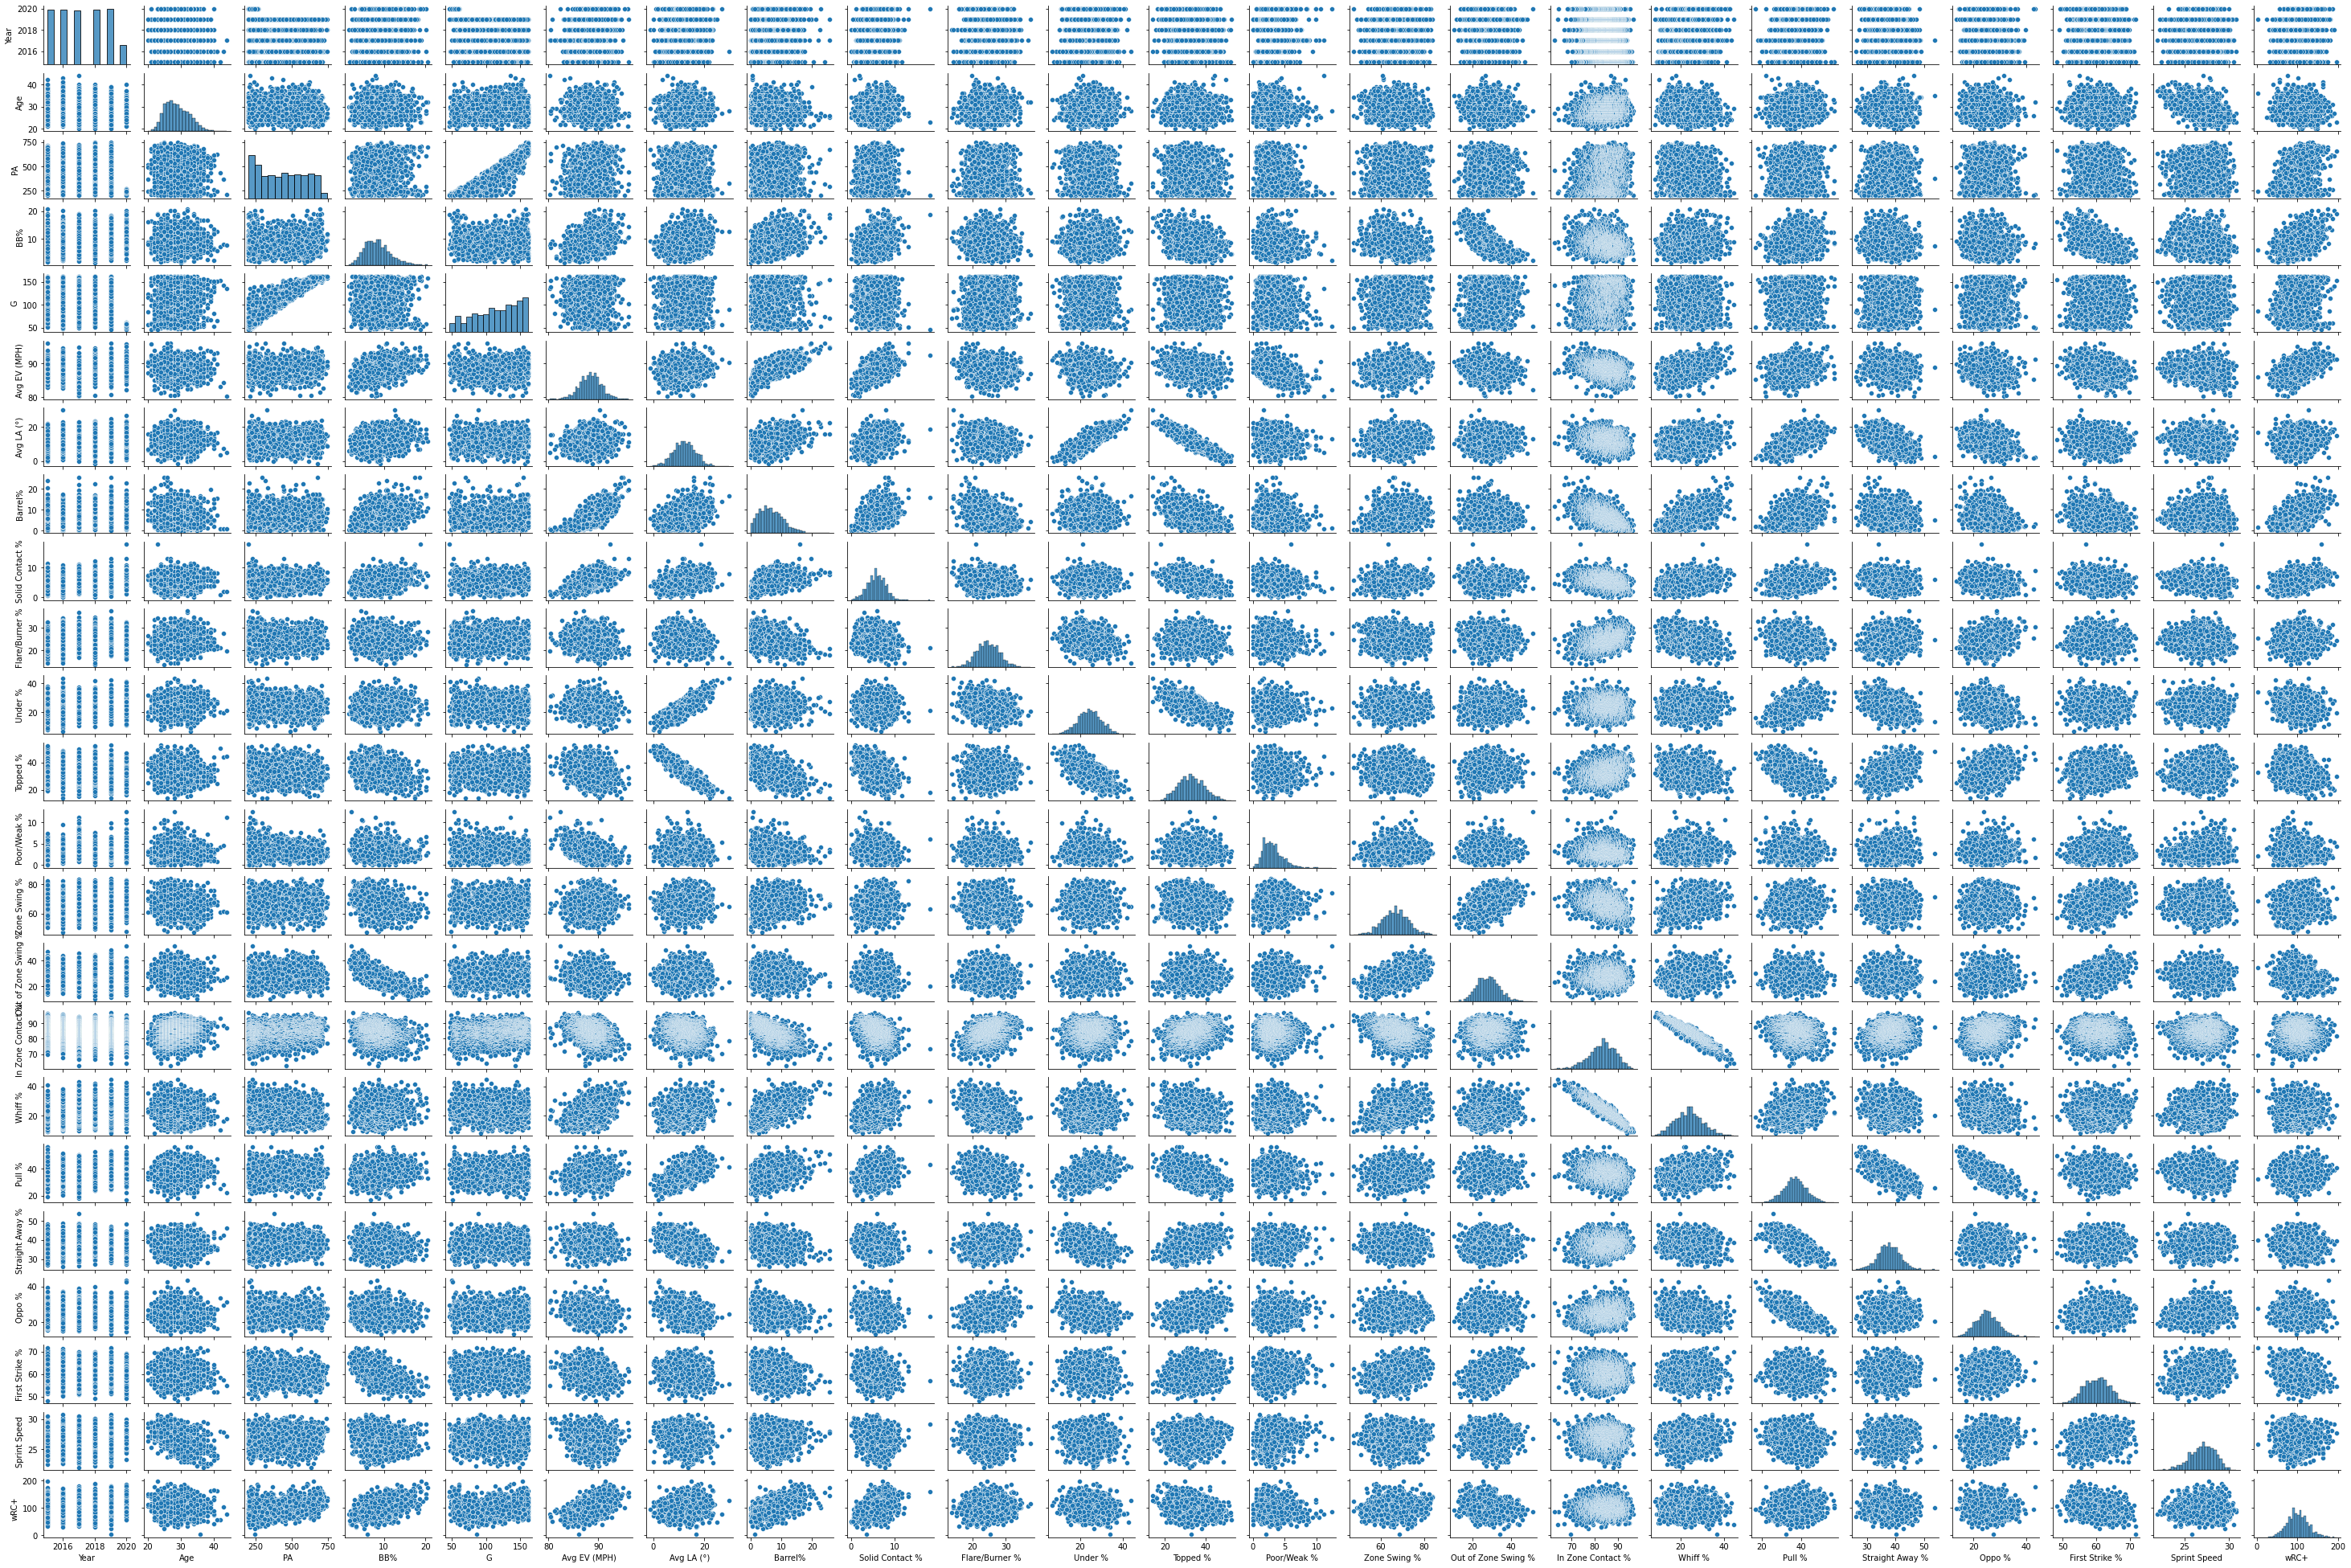

In [7]:
sns.pairplot(combined_df, height=1.2, aspect=1.5);

Based on the pairplots and nature of these stats, there is definitely some degree of collinearity.  Since I think the batted ball profile is important to explore in models without discarding terms, I will try out regularizaiton (Ridge, Lasso, ElasticNet) to smooth this out in the final model.

## Getting Ready for Modeling:

In [8]:
combined_df.columns

Index(['Player', 'Year', 'Age', 'PA', 'BB%', 'G', 'Avg EV (MPH)', 'Avg LA (°)',
       'Barrel%', 'Solid Contact %', 'Flare/Burner %', 'Under %', 'Topped %',
       'Poor/Weak %', 'Zone Swing %', 'Out of Zone Swing %',
       'In Zone Contact %', 'Whiff %', 'Pull %', 'Straight Away %', 'Oppo %',
       'First Strike %', 'Sprint Speed', 'wRC+'],
      dtype='object')

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   int64  
 2   Age                  1893 non-null   int64  
 3   PA                   1893 non-null   int64  
 4   BB%                  1893 non-null   float64
 5   G                    1893 non-null   int64  
 6   Avg EV (MPH)         1893 non-null   float64
 7   Avg LA (°)           1893 non-null   float64
 8   Barrel%              1893 non-null   float64
 9   Solid Contact %      1893 non-null   float64
 10  Flare/Burner %       1893 non-null   float64
 11  Under %              1893 non-null   float64
 12  Topped %             1893 non-null   float64
 13  Poor/Weak %          1893 non-null   float64
 14  Zone Swing %         1893 non-null   float64
 15  Out of Zone Swing %  1893 non-null   f

As before, name, Year, PA, and G will not be used in the modeling.

In [10]:
#Stating with all columns:
columns = ['Age','BB%','Avg EV (MPH)','Avg LA (°)','Barrel%','Solid Contact %',
          'Flare/Burner %','Under %','Topped %','Poor/Weak %','Zone Swing %', 'Out of Zone Swing %','In Zone Contact %','Whiff %','Pull %',
          'Straight Away %','Sprint Speed', 'Oppo %', 'First Strike %']

Importing functions for regression:

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In order to make modeling easier to compare, functions running each are in lr_validation_train.py.  Reference that file for the code.

In [7]:
from lr_validation_train import *

Validation with All columns:

In [13]:
validation_comparer(combined_df[columns], combined_df['wRC+'])

Simple Linear Regression Results:
Simple Linear Regression val R^2: 0.578
[('Age', -1.1393021432580883), ('BB%', 8.635885521544322), ('Avg EV (MPH)', 4.8729263807870495), ('Avg LA (°)', -0.949466005579449), ('Barrel%', 13.07560811670687), ('Solid Contact %', 2.4839938500578067), ('Flare/Burner %', 2.390026661931083), ('Under %', -6.403073502234974), ('Topped %', -5.837877781310984), ('Poor/Weak %', 0.2468439566940382), ('Zone Swing %', 2.30993474777891), ('Out of Zone Swing %', 4.461881829493623), ('In Zone Contact %', -3.5495126141433175), ('Whiff %', -18.15952485135606), ('Pull %', 4.864944795845796), ('Straight Away %', 1.8230356952035802), ('Sprint Speed', 5.047759882838717), ('Oppo %', 2.4887399554501415), ('First Strike %', -0.4971953513985148)]


Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.5801176864211051, 0.6336860535695004, 0.6401888948697183, 0.6515377063579442, 0.5783377828805363] 

Simple mean cv r^2: 0.617 +- 0.031


Lasso Linear Regression

Based on the above results, Ridge has the highest R^2.  Ridge R^2: 0.6312668746038839

It looks like the change in terms (adding BB% and Whiff % from previous notebook) has boosted r^2 as I thought would happen.

### Next, trying some different features:

Running just with barrel%, topped %, and Sprint Speed based on above coefficients:

In [14]:
validation_comparer(combined_df[['Barrel%', 'Topped %', 'Sprint Speed']], combined_df['wRC+'])

Simple Linear Regression Results:
Simple Linear Regression val R^2: 0.325
[('Barrel%', 13.517412767264343), ('Topped %', -1.5661487768233235), ('Sprint Speed', 2.060082354592988)]


Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.3381757773461168, 0.25827027133057856, 0.341049370609657, 0.2642224593251281, 0.2850660914248966] 

Simple mean cv r^2: 0.297 +- 0.036


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.30363323758920957
Lasso mae: 16.758477340294885
Lasso Coefficients: [('Barrel%', 13.509032536587076), ('Topped %', -1.3364970242375895), ('Sprint Speed', 2.005269634499761)]


Ridge Linear Regression w/ CV Results:
Ridge R^2: 0.30361927956347534
Ridge mae: 16.759281326161602
Ridge Coefficients: [('Barrel%', 13.409993048814348), ('Topped %', -1.3903478460323841), ('Sprint Speed', 2.002081680074902)]


ElasticNet Linear Regression w/ CV Results:
ElasticNet R^2: 0.3035602399628876
ElasticNet mae: 16.761343466668073
ElasticNet Coefficients: [('Barrel%

Original Lasso set Oppo to Zero.  Trying that:

In [15]:
#removing oppo % from columns:
columns2 = ['Age','BB%','Avg EV (MPH)','Avg LA (°)','Barrel%','Solid Contact %',
          'Flare/Burner %','Under %','Topped %','Poor/Weak %','Zone Swing %', 'Out of Zone Swing %','In Zone Contact %','Whiff %','Pull %',
          'Straight Away %','Sprint Speed', 'First Strike %']

In [16]:
validation_comparer(combined_df[columns2], combined_df['wRC+'])

Simple Linear Regression Results:
Simple Linear Regression val R^2: 0.578
[('Age', -1.1393594055590681), ('BB%', 8.637063012420132), ('Avg EV (MPH)', 4.870206647135813), ('Avg LA (°)', -0.9530823271230414), ('Barrel%', 13.074919034034048), ('Solid Contact %', 2.4847887632273147), ('Flare/Burner %', 2.3906805721021747), ('Under %', -6.400733108651408), ('Topped %', -5.836270440009567), ('Poor/Weak %', 0.24544876398658708), ('Zone Swing %', 2.308723949343691), ('Out of Zone Swing %', 4.462334355723339), ('In Zone Contact %', -3.5476375449661854), ('Whiff %', -18.154261043471617), ('Pull %', 1.3993812258525955), ('Straight Away %', -0.4968899672565484), ('Sprint Speed', 5.048026332552358), ('First Strike %', -0.49725537116280893)]


Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.5802317051156498, 0.6336739330745562, 0.6402914222272593, 0.6517846844306607, 0.5784696982576918] 

Simple mean cv r^2: 0.617 +- 0.031


Lasso Linear Regression w/ CV Results:
Lasso R^

Same results - decision to keep oppo, let regularization take care of the features.

## Running Lasso with Polynomial Features

Code for running is in lasso_polynomial.py

In [17]:
from lasso_polynomial import *

In [18]:
lasso_polynomial_lr(combined_df[columns], combined_df['wRC+'])

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.12920504901558, tolerance: 78.46806787778696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.41013879486127, tolerance: 78.46806787778696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221.38179605297046, tolerance: 78.46806787778696
  model = cd_fast.enet_coordinate_descent_gram(

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.56372705986723, tolerance: 77.89618464079275
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 333.5255884886137, tolerance: 77.89618464079275
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.4965684124036, tolerance: 77.89618464079275
  model = cd_fast.enet_coordinate_descent_gram(


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.644195797919662
Lasso mae: 11.904176526006014
Lasso Coefficients: [('1', 0.0), ('x0', -0.0), ('x1', 0.0), ('x2', 0.9401562063854756), ('x3', 0.0), ('x4', 0.0), ('x5', 0.0), ('x6', 0.0), ('x7', -0.0), ('x8', -0.0), ('x9', -0.0), ('x10', 0.0), ('x11', 0.0), ('x12', -0.0), ('x13', -0.0), ('x14', 0.0), ('x15', -0.0), ('x16', 0.0), ('x17', -0.0), ('x18', -0.0), ('x0^2', -0.0), ('x0 x1', 0.0), ('x0 x2', -0.0), ('x0 x3', 0.0), ('x0 x4', 0.0), ('x0 x5', -0.0), ('x0 x6', -0.0), ('x0 x7', -0.0), ('x0 x8', -0.0), ('x0 x9', 0.0), ('x0 x10', 0.0), ('x0 x11', 0.0), ('x0 x12', -0.0), ('x0 x13', -0.46982883064964553), ('x0 x14', 0.0), ('x0 x15', -0.515115668286978), ('x0 x16', -0.0), ('x0 x17', -0.0), ('x0 x18', -0.0010820955034165141), ('x1^2', 1.0677729203839987), ('x1 x2', 0.0), ('x1 x3', 1.7211368299210144), ('x1 x4', 0.0), ('x1 x5', 0.0), ('x1 x6', 0.0), ('x1 x7', 0.0), ('x1 x8', 0.0), ('x1 x9', -0.0), ('x1 x10', 1.281237625673924), ('x1 x11', 3

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 747.8221878003096, tolerance: 77.07936130363036
  model = cd_fast.enet_coordinate_descent_gram(


## Of all the models, Poly Lasso performed the best on train/val.  However, for the sake of interpretability I want to pick the top interactions to include in my model.  I'd prefer to have better interpretibility, and not have this large mix of terms.

# FINAL MODEL:

Relationships from Poly Lasso with high coef (> 3 absolute value):

x1 x11', 3.47505772320006  
x4 x8', 4.523619434572244  
x2 x16', 4.4029460005033805  
x4 x12', 8.654991283114777  
x7 x8', -3.6093814518368594  
x12 x13', -6.211380194392772  
x13^2', -4.143789920392344  

Printing columns to interpret relationships:

In [19]:
combined_df[columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1893 non-null   int64  
 1   BB%                  1893 non-null   float64
 2   Avg EV (MPH)         1893 non-null   float64
 3   Avg LA (°)           1893 non-null   float64
 4   Barrel%              1893 non-null   float64
 5   Solid Contact %      1893 non-null   float64
 6   Flare/Burner %       1893 non-null   float64
 7   Under %              1893 non-null   float64
 8   Topped %             1893 non-null   float64
 9   Poor/Weak %          1893 non-null   float64
 10  Zone Swing %         1893 non-null   float64
 11  Out of Zone Swing %  1893 non-null   float64
 12  In Zone Contact %    1893 non-null   float64
 13  Whiff %              1893 non-null   float64
 14  Pull %               1893 non-null   float64
 15  Straight Away %      1893 non-null   f

In [20]:
combined_df['BB%*OutOfZone%'] = combined_df['BB%'] * combined_df['Out of Zone Swing %']
combined_df['Barrel%*Topped%'] = combined_df['Barrel%'] * combined_df['Topped %']
combined_df['Avg EV (MPH)*Sprint Speed'] = combined_df['Avg EV (MPH)'] * combined_df['Sprint Speed']
combined_df['Barrel%*In Zone Contact %'] = combined_df['Barrel%'] * combined_df['In Zone Contact %']
combined_df['Under %*Topped %'] = combined_df['Under %'] * combined_df['Topped %']
combined_df['In Zone Contact % * Whiff %'] = combined_df['In Zone Contact %'] * combined_df['Whiff %']
combined_df['Whiff %**2']  =combined_df['Whiff %'] **2

In [21]:
columns_poly_r = ['Age','BB%','Avg EV (MPH)','Avg LA (°)','Barrel%','Solid Contact %',
          'Flare/Burner %','Under %','Topped %','Poor/Weak %','Zone Swing %', 'Out of Zone Swing %','In Zone Contact %','Whiff %','Pull %',
          'Straight Away %','Sprint Speed', 'Oppo %', 'First Strike %', 'BB%*OutOfZone%', 'Barrel%*Topped%', 'Avg EV (MPH)*Sprint Speed', 'Barrel%*In Zone Contact %', 'Under %*Topped %', 'In Zone Contact % * Whiff %', 'Whiff %**2']

In [22]:
validation_comparer(combined_df[columns_poly_r], combined_df['wRC+'])

Simple Linear Regression Results:
Simple Linear Regression val R^2: 0.589
[('Age', -1.1549005410733595), ('BB%', 5.003677456202596), ('Avg EV (MPH)', 4.665762606659376), ('Avg LA (°)', -0.12252495727391334), ('Barrel%', -9.974947291831045), ('Solid Contact %', 1.9809819737215124), ('Flare/Burner %', 2.0025801379645043), ('Under %', -3.1114134021572726), ('Topped %', -5.072152347066769), ('Poor/Weak %', 0.08420368337286667), ('Zone Swing %', 2.132941832324968), ('Out of Zone Swing %', 2.5158065027075445), ('In Zone Contact %', -10.74684889708748), ('Whiff %', -47.02338599977127), ('Pull %', 8.36647096279022), ('Straight Away %', 4.152061299414301), ('Sprint Speed', 5.964681318447101), ('Oppo %', 4.9666202559924875), ('First Strike %', -0.3976562277810369), ('BB%*OutOfZone%', 2.773221950449943), ('Barrel%*Topped%', 7.190456320122941), ('Avg EV (MPH)*Sprint Speed', -0.6568624701492751), ('Barrel%*In Zone Contact %', 14.34545095117173), ('Under %*Topped %', -3.431139006396143), ('In Zone C

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.28915256931214, tolerance: 78.46806787778696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339.46655435691355, tolerance: 78.46806787778696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.6339526320226, tolerance: 78.46806787778696
  model = cd_fast.enet_coordinate_descent_gram(

Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.640161843849534
Lasso mae: 11.985153376017083
Lasso Coefficients: [('Age', -0.6548636881591122), ('BB%', 4.1545277917256405), ('Avg EV (MPH)', 0.27268823376573403), ('Avg LA (°)', -0.0), ('Barrel%', 0.0), ('Solid Contact %', 2.03255404907359), ('Flare/Burner %', 2.8243459429233315), ('Under %', -0.0), ('Topped %', -1.6066299807380253), ('Poor/Weak %', 0.2106080834914677), ('Zone Swing %', 2.2788711244869604), ('Out of Zone Swing %', 1.6208943771941726), ('In Zone Contact %', -0.0), ('Whiff %', -0.0), ('Pull %', 1.0183481785858168), ('Straight Away %', -0.42764160056416145), ('Sprint Speed', 0.0), ('Oppo %', -0.0), ('First Strike %', -0.17368555707231137), ('BB%*OutOfZone%', 3.2012250229208647), ('Barrel%*Topped%', 6.595228889193817), ('Avg EV (MPH)*Sprint Speed', 5.556277262772611), ('Barrel%*In Zone Contact %', 7.853258806223545), ('Under %*Topped %', -4.506660439834902), ('In Zone Contact % * Whiff %', -8.18491415600635), ('Whiff %*

Ridge with the Interaction terms included has the best R^2 (Ridge R^2: 0.6412499147225041), outside of the Lasso Poly result.  Therefore, I am going to utilize this model, for two reasons:
- Interpretability remains, with the original features included and the top interaction terms added.
- The gain in R^2 using Lasso Poly (0.644195797919662) to me does not justify the loss in interpretibility.

## Testing, with Ridge and the interaction terms.

Let's look at the test set results with Ridge:

In [23]:
X, y = combined_df[columns_poly_r], combined_df['wRC+']

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=5)
std = StandardScaler()
std.fit(X_train_val.values)
X_train_val_scaled = std.transform(X_train_val.values)
    
ridge_model = RidgeCV(cv= 5)
ridge_model.fit(X_train_val_scaled, y_train_val)
    
train_val_pred = ridge_model.predict(X_train_val_scaled)
ridge_mae = mae(y_train_val, train_val_pred)
ridge_r2 = r2_score(y_train_val, train_val_pred)

In [25]:
X_test_scaled = std.transform(X_test.values)

In [26]:
test_set_pred = ridge_model.predict(X_test_scaled)

In [27]:
mae(y_test, test_set_pred)

12.562579745800075

Within this use case, being off by 12.56 is basically saying on average, you could predict someone to be 12.56% above or below league average, when they are a league average player.  Not awful.

In [28]:
r2_score(y_test, test_set_pred)

0.6526760287078031

Testing outperformed train (0.6412499147225041).  Possible outliers in the training data?

## From test data, let's look at residuals:

Residual Plot:

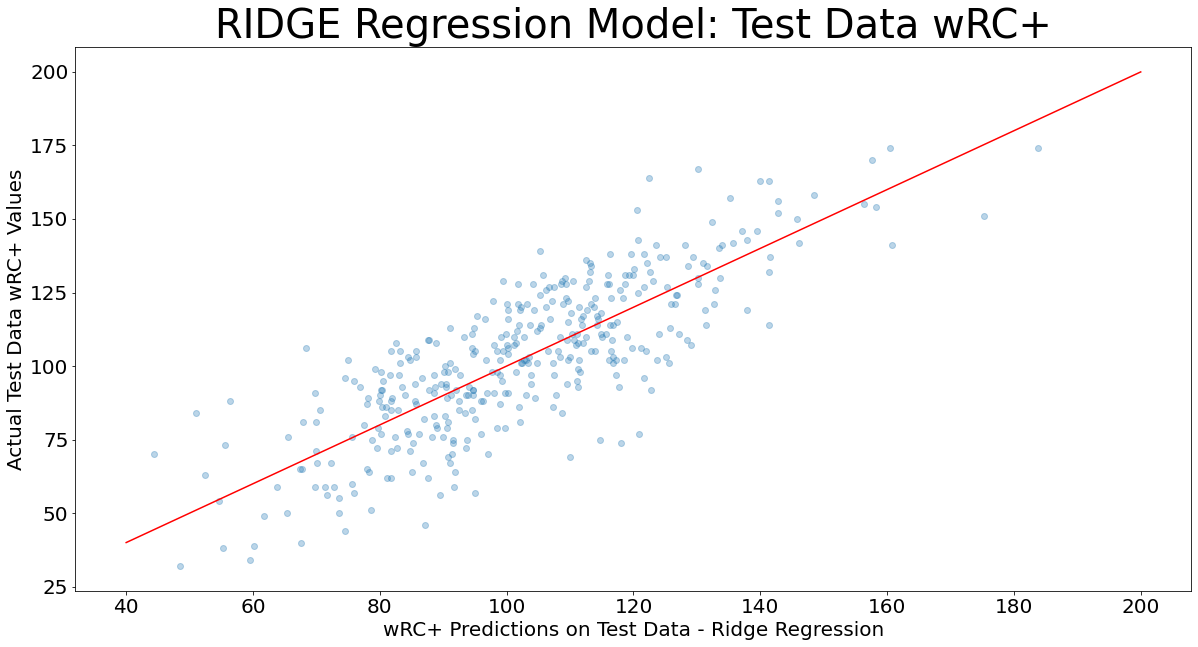

In [29]:
plt.scatter(test_set_pred, y_test, alpha=.3)
plt.plot(np.linspace(40,200), np.linspace(40,200), color='red')
plt.xlabel('wRC+ Predictions on Test Data - Ridge Regression', size=20)
plt.ylabel('Actual Test Data wRC+ Values', size=20)
plt.title('RIDGE Regression Model: Test Data wRC+', size=40)
plt.xticks(size=20)
plt.yticks(size=20);

In [30]:
X_new = std.transform(combined_df[columns_poly_r])

In [31]:
combined_df['prediction'] = ridge_model.predict(X_new)

In [32]:
combined_df['residual'] = combined_df['wRC+'] - combined_df.prediction

In [33]:
combined_df['prediction'].mean()

101.20259165999185

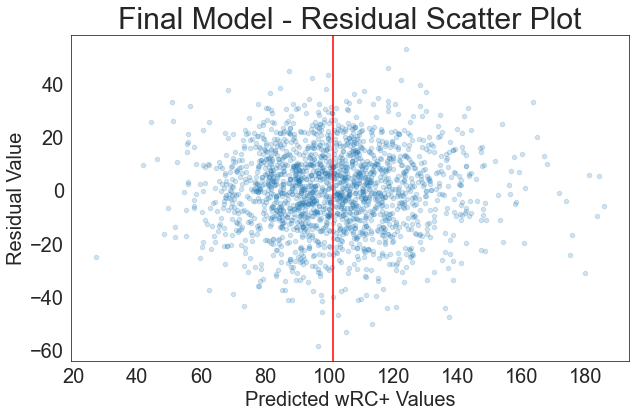

In [34]:
with sns.axes_style('white'):
    plot=combined_df.plot(kind='scatter',
                  x='prediction',y='residual',alpha=0.2,figsize=(10,6))
    plt.axvline(combined_df['prediction'].mean(), 0, color='red')
    plt.title("Final Model - Residual Scatter Plot", size='30')
    plt.xlabel('Predicted wRC+ Values', size=20)
    plt.ylabel('Residual Value', size=20)
    plt.xticks(size=20)
    plt.yticks(size=20);
    plt.show()

Q-Q Plot:

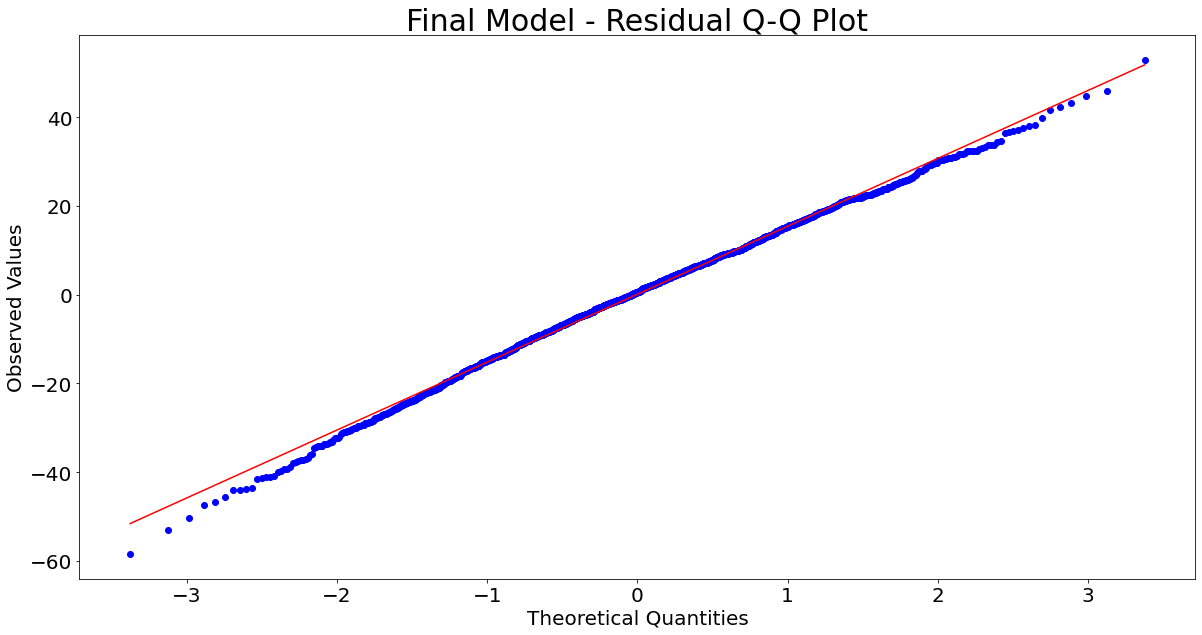

In [35]:
stats.probplot(combined_df['residual'], dist="norm", plot=plt)
plt.title("Final Model - Residual Q-Q Plot", size='30')
plt.xlabel('Theoretical Quantities', size=20)
plt.ylabel('Observed Values', size=20)
plt.xticks(size=20)
plt.yticks(size=20);
plt.show()

Variance of Error Terms:

No interaction terms:

In [36]:
import statsmodels.api as sm
X, y = combined_df[columns], combined_df['wRC+']
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   wRC+   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              4409.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):                        0.00
Time:                        11:54:17   Log-Likelihood:                         -7869.2
No. Observations:                1893   AIC:                                  1.578e+04
Df Residuals:                    1874   BIC:                                  1.588e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                    -0.2068      0.108     -1.912      0.056      -0.419       0.005
BB%                     2.6868      0.202     13.321      0.000       2.291       3.082
Avg EV (MPH)            1.4559      0.363      4.009      0.000       0.744       2.168
Avg LA (°)             -0.3532      0.345     -1.024      0.306      -1.030       0.323
Barrel%                 3.9573      0.275     14.397      0.000       3.418       4.496
Solid Contact %         1.3307      0.299      4.447      0.000       0.744       1.918
Flare/Burner %          1.0266      0.224      4.592      0.000       0.588       1.465
Under %                -0.8136      0.254     -3.209      0.001      -1.311      -0.316
Topped %               -0.5951      0.248     -2.396      0.017      -1.082      -0.108
Poor/Weak %             0.2498      0.360      0.694      0.488      -0.457       0.956
Zone Swing %            0.4591      0.080      5.744      0.000       0.302       0.616
Out of Zone Swing %     0.6784      0.106      6.391      0.000       0.470       0.887
In Zone Contact %      -0.6209      0.202     -3.080      0.002      -1.016      -0.226
Whiff %                -2.8256      0.184    -15.315      0.000      -3.187      -2.464
Pull %                 -0.5905      0.448     -1.318      0.188      -1.469       0.288
Straight Away %        -0.9451      0.451     -2.093      0.036      -1.831      -0.060
Sprint Speed            3.4527      0.301     11.474      0.000       2.863       4.043
Oppo %                 -0.8166      0.444     -1.840      0.066      -1.687       0.054
First Strike %         -0.1104      0.121     -0.916      0.360      -0.347       0.126
==============================================================================
Omnibus:                       17.250   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.590
Skew:                          -0.218   Prob(JB):                     0.000151
Kurtosis:                       3.179   Cond. No.                         438.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

w/ Interaction Terms:

In [37]:
import statsmodels.api as sm
X, y = combined_df[columns_poly_r], combined_df['wRC+']
model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   wRC+   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              3292.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):                        0.00
Time:                        11:54:17   Log-Likelihood:                         -7845.7
No. Observations:                1893   AIC:                                  1.574e+04
Df Residuals:                    1867   BIC:                                  1.589e+04
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Age                            -0.2094      0.108     -1.944      0.052      -0.421       0.002
BB%                             1.7356      0.449      3.863      0.000       0.855       2.617
Avg EV (MPH)                    1.2289      2.818      0.436      0.663      -4.297       6.755
Avg LA (°)                     -0.1404      0.344     -0.408      0.684      -0.815       0.535
Barrel%                        -1.7667      1.654     -1.068      0.286      -5.011       1.478
Solid Contact %                 1.0268      0.306      3.356      0.001       0.427       1.627
Flare/Burner %                  0.9176      0.226      4.062      0.000       0.475       1.361
Under %                        -0.4165      0.395     -1.055      0.292      -1.191       0.358
Topped %                       -0.5423      0.331     -1.639      0.101      -1.191       0.107
Poor/Weak %                     0.1464      0.359      0.407      0.684      -0.558       0.851
Zone Swing %                    0.4236      0.080      5.325      0.000       0.268       0.580
Out of Zone Swing %             0.3946      0.156      2.533      0.011       0.089       0.700
In Zone Contact %              -1.5148      0.843     -1.798      0.072      -3.168       0.138
Whiff %                        -5.1888      3.985     -1.302      0.193     -13.004       2.627
Pull %                          0.5779      2.620      0.221      0.825      -4.561       5.717
Straight Away %                 0.2153      2.625      0.082      0.935      -4.933       5.364
Sprint Speed                    3.5545      9.097      0.391      0.696     -14.286      21.395
Oppo %                          0.3676      2.620      0.140      0.888      -4.771       5.506
First Strike %                 -0.0876      0.120     -0.729      0.466      -0.323       0.148
BB%*OutOfZone%                  0.0383      0.017      2.266      0.024       0.005       0.071
Barrel%*Topped%                 0.0545      0.015      3.614      0.000       0.025       0.084
Avg EV (MPH)*Sprint Speed       0.0003      0.103      0.003      0.997      -0.201       0.202
Barrel%*In Zone Contact %       0.0500      0.022      2.313      0.021       0.008       0.092
Under %*Topped %               -0.0194      0.009     -2.123      0.034      -0.037      -0.001
In Zone Contact % * Whiff %     0.0182      0.032      0.562      0.574      -0.045       0.082
Whiff %**2                      0.0147      0.027      0.545      0.586      -0.038       0.068
==============================================================================
Omnibus:                       16.052   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Ja

Most of this was added w/ the interaction terms, which makes sense compared to the original columns.

## Feature Histogram

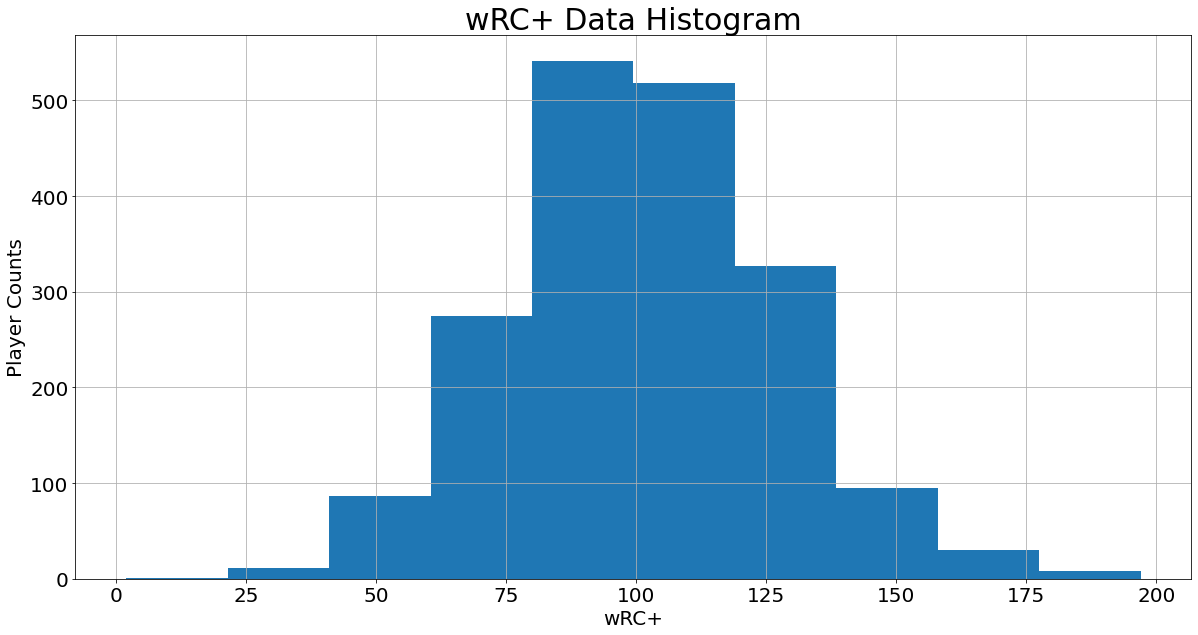

In [38]:
combined_df['wRC+'].hist(bins=10)
plt.title("wRC+ Data Histogram", size='30')
plt.xlabel('wRC+', size=20)
plt.ylabel('Player Counts', size=20)
plt.xticks(size=20)
plt.yticks(size=20);
plt.show()

Pretty normal distribution, maybe a slightly right skew (more people to the left).

### Box Cox:

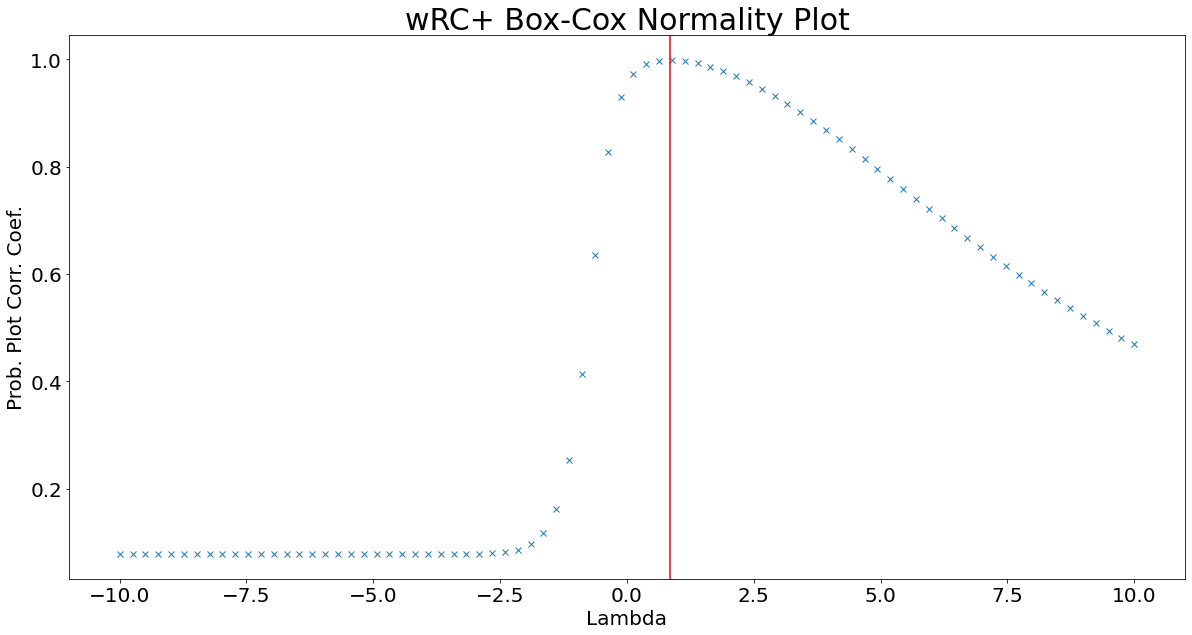

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(combined_df['wRC+'], -10, 10, plot=ax)
_, maxlog = stats.boxcox(combined_df['wRC+'])
ax.axvline(maxlog, color='r')
plt.title("wRC+ Box-Cox Normality Plot", size='30')
plt.xlabel('Lambda', size=20)
plt.ylabel('Prob. Plot Corr. Coef.', size=20)
plt.xticks(size=20)
plt.yticks(size=20);
plt.show()

In [40]:
maxlog

0.8504615270954586

Based on this lambda value, I am ok with keeping as normal (lambda close to 1).

## Exploring some of the high residuals more:

Looking at under predictions:

In [41]:
combined_df.sort_values(by='residual', ascending=False).head(10)

Player  Year  Age   PA   BB%    G  Avg EV (MPH)  \
52            LeMahieu, DJ  2020   32  216   8.3   50          91.3   
1566          Cruz, Nelson  2020   40  214  11.7   53          91.6   
764     Hernandez, Enrique  2015   24  218   5.0   76          90.4   
1790      Colabello, Chris  2015   32  360   6.1  101          90.0   
1077        Blanco, Andres  2015   31  261   8.0  106          87.1   
1807           Olson, Matt  2017   23  216  10.2   59          92.2   
213          Bregman, Alex  2019   25  690  17.2  156          89.3   
1742   Bradley Jr., Jackie  2015   25  255  10.6   74          89.2   
339           McNeil, Jeff  2018   26  248   5.6   63          86.6   
1229       Suarez, Eugenio  2015   24  398   4.3   97          88.5   

      Avg LA (°)  Barrel%  Solid Contact %  ...  wRC+  BB%*OutOfZone%  \
52           2.3      2.9              9.1  ...   177          200.03   
1566         9.4     15.0              3.9  ...   164          360.36   
764         11.0      5.0              6.3  ...   132          159.00   
1790         9.8      9.2              5.0  ...   143          192.15   
1077        10.6      5.2              4.7  ...   137          237.60   
1807        17.4     16.3              6.2  ...   164          255.00   
213         19.6      4.8              9.8  ...   168          271.76   
1742        10.5      6.4              9.0  ...   123          266.06   
339         15.5      2.4              4.9  ...   137          182.00   
1229        14.9      5.3              4.2  ...   106          107.50   

      Barrel%*Topped%  Avg EV (MPH)*Sprint Speed  Barrel%*In Zone Contact %  \
52             122.67                    2382.93                     269.41   
1566           519.00                    2308.32                    1170.00   
764            179.00                    2458.88                     424.50   
1790           322.92                    2349.00                     678.96   
1077           195.00                    2334.28                     430.56   
1807           417.28                    2240.46                    1191.53   
213            120.48                    2446.82                     432.00   
1742           254.08                    2453.00                     480.00   
339             71.52                    2407.48                     212.64   
1229           165.89                    2389.50                     431.95   

      Under %*Topped %  In Zone Contact % * Whiff %  Whiff %**2  prediction  \
52              507.60                      1040.48      125.44  124.128069   
1566            626.26                      2667.60     1169.64  118.231305   
764             766.12                      2249.85      702.25   87.327493   
1790            603.72                      2302.56      973.44   99.723973   
1077            858.75                      1829.88      488.41   94.679525   
1807            614.40                      2339.20     1024.00  122.517610   
213             848.38                      1287.00      204.49  128.309204   
1742            992.50                      2287.50      930.25   84.742273   
339             888.04                      1435.32      262.44   99.060164   
1229            970.30                      2070.10      645.16   68.363464   

       residual  
52    52.871931  
1566  45.768695  
764   44.672507  
1790  43.276027  
1077  42.320475  
1807  41.482390  
213   39.690796  
1742  38.257727  
339   37.939836  
1229  37.636536  

[10 rows x 33 columns]

Guys with high walk rates are gone, with the remaining being BABIP outliers

BABIP on above:

- Nelson Cruz 2020: .360
- LaMahieu 2020: BABIP of .370 - that is extremely high.  Won the AL Batting Title in 2020.
- Chris Colabello 2015: .411 BABIP, which is insane.
- Enrique Hernandez 2015: .359
- Andres Blanco 2015: .335
- Tim Anderson 2020: .383 BABIP
- Bregman 2019: BABIP of .281, that's not that odd, and even unlucky.  Walk rate of 17.2% - no. 3 in baseball in 2019. Finished second in 2019 MVP voting.
- Suarez: .341 BABIP

And Over predictions:

In [42]:
combined_df.sort_values(by='residual', ascending=True).head(10)

Player  Year  Age   PA   BB%    G  Avg EV (MPH)  Avg LA (°)  \
1454      Reyes, Victor  2018   24  219   2.3  100          85.4         6.2   
729         Uribe, Juan  2016   37  259   5.8   73          88.1        10.1   
379    Morales, Kendrys  2019   36  201  12.9   53          91.3         9.5   
1561    Schwarber, Kyle  2020   27  224  13.4   59          92.8         8.8   
491    Escobar, Eduardo  2020   31  222   6.8   54          88.6        18.1   
780       Owings, Chris  2018   27  309   7.8  106          87.8        13.4   
920     Cabrera, Miguel  2017   34  529  10.2  130          91.3        12.5   
1603     Altherr, Aaron  2018   27  285  12.6  105          90.4        10.2   
1396      Odor, Rougned  2019   25  581   9.0  145          91.1        17.9   
1060         Gomes, Yan  2016   29  264   3.4   74          87.0        16.8   

      Barrel%  Solid Contact %  ...  wRC+  BB%*OutOfZone%  Barrel%*Topped%  \
1454      3.0              3.6  ...    38          101.20           119.70   
729       7.3              5.7  ...    52          180.38           254.77   
379       6.9              6.2  ...    63          276.06           261.51   
1561     11.2              8.8  ...    90          369.84           367.36   
491       5.5              3.7  ...    56          239.36           147.40   
780       5.8              6.3  ...    52          265.20           192.56   
920      10.5             10.8  ...    92          309.06           289.80   
1603      9.7             10.4  ...    74          286.02           333.68   
1396     13.6              6.4  ...    77          266.40           369.92   
1060      5.4              8.2  ...    30          127.84           161.46   

      Avg EV (MPH)*Sprint Speed  Barrel%*In Zone Contact %  Under %*Topped %  \
1454                    2493.68                     238.20            618.45   
729                     2246.55                     621.96            746.86   
379                     2145.55                     608.58            784.53   
1561                    2496.32                     874.72            629.76   
491                     2480.80                     479.05            897.80   
780                     2484.74                     491.84            926.28   
920                     2273.37                     880.95            532.68   
1603                    2621.60                     751.75            646.72   
1396                    2550.80                    1086.64            794.24   
1060                    2314.20                     447.12           1007.63   

      In Zone Contact % * Whiff %  Whiff %**2  prediction   residual  
1454                      1754.74      488.41   96.455258 -58.455258  
729                       1797.72      445.21  105.090649 -53.090649  
379                       1578.78      320.41  113.372761 -50.372761  
1561                      2202.42      795.24  137.419959 -47.419959  
491                       1881.36      466.56  102.659994 -46.659994  
780                       2086.08      605.16   97.610159 -45.610159  
920                       1938.09      533.61  136.108946 -44.108946  
1603                      2542.00     1075.84  118.051819 -44.051819  
1396                      2349.06      864.36  120.840065 -43.840065  
1060                      2070.00      625.00   73.454096 -43.454096  

[10 rows x 33 columns]

Looking at some players with small residuals:

In [43]:
combined_df[(abs(combined_df['residual']) < 4) & (combined_df.Year == 2020)].sort_values(by='wRC+').head(25)

Player  Year  Age   PA   BB%   G  Avg EV (MPH)  Avg LA (°)  \
1608    Villar, Jonathan  2020   29  207   9.2  52          86.7         1.6   
1688     Garcia, Avisail  2020   29  207   9.7  53          87.4         8.7   
323      Alberto, Hanser  2020   28  231   2.2  54          82.3        13.2   
1890       Hiura, Keston  2020   24  246   6.5  59          87.4        14.3   
1254      Semien, Marcus  2020   30  236  10.6  53          86.2        19.3   
1253       Reyes, Victor  2020   26  213   4.2  57          90.0        10.7   
1656    Dickerson, Corey  2020   31  210   7.1  52          85.7        11.1   
804    Blackmon, Charlie  2020   34  247   7.7  59          86.9        13.5   
1880        Robert, Luis  2020   23  227   8.8  56          87.9        16.7   
1205     Cabrera, Miguel  2020   37  231  10.4  57          93.2        12.1   
1548     Suarez, Eugenio  2020   29  231  13.0  57          89.1        17.9   
348     Merrifield, Whit  2020   31  265   4.5  60          86.1        15.8   
922         Segura, Jean  2020   30  217  10.6  54          87.7        11.2   
1813      Devers, Rafael  2020   24  248   5.2  57          93.0        10.6   
1149   Walker, Christian  2020   29  243   7.8  57          90.4        11.5   
1058         Votto, Joey  2020   37  223  16.6  54          87.4        15.4   
1785     Swanson, Dansby  2020   26  264   8.3  60          89.1        14.7   
1207       Story, Trevor  2020   28  259   9.3  59          89.9        20.8   
520         Seager, Kyle  2020   33  248  12.9  60          89.1        17.7   
1090        Tucker, Kyle  2020   23  228   7.9  58          91.1        14.9   
1824       Taylor, Chris  2020   30  214  12.1  56          88.0         9.1   
635        Seager, Corey  2020   26  232   7.3  52          93.2        11.9   

      Barrel%  Solid Contact %  ...  wRC+  BB%*OutOfZone%  Barrel%*Topped%  \
1608      1.5              3.7  ...    66          309.12            63.75   
1688      3.8              8.3  ...    81          335.62           155.42   
323       1.0              3.1  ...    87          112.86            32.10   
1890     14.2              4.5  ...    87          197.60           455.82   
1254      5.0              6.8  ...    91          196.10           124.00   
1253      3.8              6.4  ...    92          174.72           130.72   
1656      5.7              3.1  ...    95          235.01           189.81   
804       4.9              5.5  ...    97          228.69           137.20   
1880     13.0              9.2  ...   101          348.48           396.50   
1205      9.7              5.8  ...   103          310.96           281.30   
1548     14.4              5.3  ...   104          310.70           393.12   
348       5.1              4.6  ...   106          125.10           130.05   
922       6.1              3.4  ...   107          327.54           197.64   
1813     12.1              5.5  ...   109          199.68           417.45   
1149      6.4             10.5  ...   110          233.22           179.84   
1058      9.1              9.8  ...   114          285.52           254.80   
1785     11.4              4.8  ...   116          199.20           286.14   
1207      8.7              7.6  ...   117          262.26           172.26   
520      10.2              6.3  ...   118          265.74           237.66   
1090      9.1              6.7  ...   125          207.77           254.80   
1824     11.5              8.4  ...   131          209.33           359.95   
635      15.8             13.0  ...   151          221.19           420.28   

      Avg EV (MPH)*Sprint Speed  Barrel%*In Zone Contact %  Under %*Topped %  \
1608                    2349.57                     116.10            731.00   
1688                    2447.20                     289.18            838.45   
323                     2205.64                      88.70            731.88   
1890                    2359.80                     914.48    

### Overall Plot of the PRediction vs. Actual

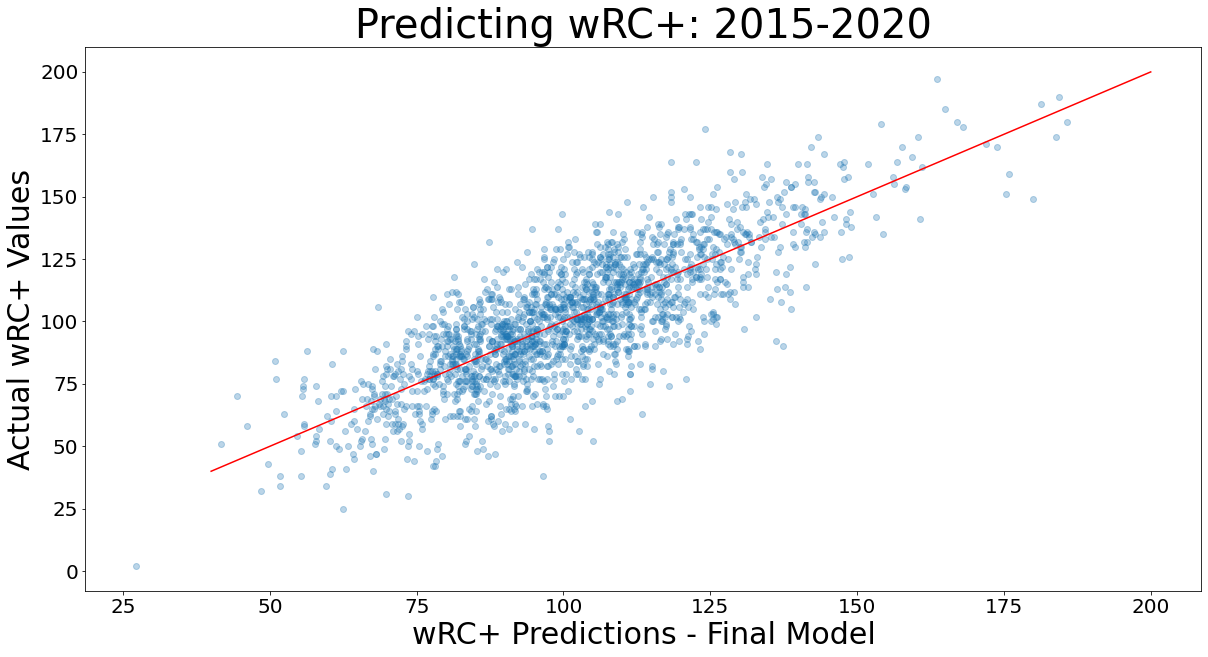

In [44]:
plt.scatter(combined_df['prediction'], combined_df['wRC+'], alpha=.3)
plt.plot(np.linspace(40,200), np.linspace(40,200), color='red')
plt.xlabel('wRC+ Predictions - Final Model', size=30)
plt.ylabel('Actual wRC+ Values', size=30)
plt.title('Predicting wRC+: 2015-2020', size=40)
plt.xticks(size=20)
plt.yticks(size=20);

Max:

In [81]:
combined_df.sort_values(by='wRC+').tail()

Player  Year  Age   PA   BB%    G  Avg EV (MPH)  Avg LA (°)  \
542         Trout, Mike  2019   28  600  18.3  134          90.9        22.2   
218       Betts, Mookie  2018   26  614  13.2  136          92.2        18.4   
768    Freeman, Freddie  2020   31  262  17.2   60          92.4        17.2   
272         Trout, Mike  2018   27  608  20.1  140          91.2        18.6   
1194      Harper, Bryce  2015   23  654  19.0  153          91.4        14.7   

      Barrel%  Solid Contact %  ...  wRC+  BB%*OutOfZone%  Barrel%*Topped%  \
542      18.9              7.1  ...   180          325.74           319.41   
218      14.1              8.1  ...   185          212.52           305.97   
768      14.7              4.5  ...   187          442.04           307.23   
272      16.5              8.3  ...   190          361.80           325.05   
1194     12.9              7.1  ...   197          484.50           385.71   

      Avg EV (MPH)*Sprint Speed  Barrel%*In Zone Contact %  Under %*Topped %  \
542                     2663.37                    1638.63            491.79   
218                     2590.82                    1267.59            598.92   
768                     2439.36                    1246.56            543.40   
272                     2663.04                    1473.45            543.72   
1194                    2531.78                    1055.22            583.05   

      In Zone Contact % * Whiff %  Whiff %**2  prediction   residual  
542                       1664.64      368.64  185.801042  -5.801042  
218                       1393.45      240.25  164.968240  20.031760  
768                       1704.48      404.01  181.342657   5.657343  
272                       1660.98      345.96  184.450480   5.549520  
1194                      2208.60      729.00  163.676509  33.323491  

[5 rows x 33 columns]

## SO WHAT of the Project:

My ultimate goal: being able to use to focus a player's training.  Thus, find two players where I can adjust stats and see result.

## Two Players Picked for Case Study:

### Keston Hiura, 2020

In [45]:
hiura = combined_df.iloc[1890, :]

In [46]:
hiura

Player                          Hiura, Keston
Year                                     2020
Age                                        24
PA                                        246
BB%                                  6.500000
G                                          59
Avg EV (MPH)                        87.400000
Avg LA (°)                          14.300000
Barrel%                             14.200000
Solid Contact %                      4.500000
Flare/Burner %                      22.400000
Under %                             21.600000
Topped %                            32.100000
Poor/Weak %                          4.500000
Zone Swing %                        71.300000
Out of Zone Swing %                 30.400000
In Zone Contact %                   64.400000
Whiff %                             42.700000
Pull %                              35.800000
Straight Away %                     40.300000
Oppo %                              23.900000
First Strike %                    

### Luis Robert, 2020:

In [47]:
robert = combined_df.iloc[1880, :]

In [48]:
robert

Player                          Robert, Luis
Year                                    2020
Age                                       23
PA                                       227
BB%                                 8.800000
G                                         56
Avg EV (MPH)                       87.900000
Avg LA (°)                         16.700000
Barrel%                            13.000000
Solid Contact %                     9.200000
Flare/Burner %                     16.000000
Under %                            24.400000
Topped %                           30.500000
Poor/Weak %                         5.300000
Zone Swing %                       80.800000
Out of Zone Swing %                39.600000
In Zone Contact %                  68.500000
Whiff %                            41.600000
Pull %                             32.800000
Straight Away %                    38.200000
Oppo %                             29.000000
First Strike %                     67.800000
Sprint Spe

In [49]:
for column in columns_poly_r:
    print('{}: Mean: {}, Std: {}'.format(column, combined_df[column].mean(), combined_df[column].std()))

Age: Mean: 28.826730058108822, Std: 3.8160094120014927
BB%: Mean: 8.51986265187533, Std: 3.169189107733371
Avg EV (MPH): Mean: 88.41331220285261, Std: 2.215766649700268
Avg LA (°): Mean: 12.229688325409404, Std: 4.386682922124166
Barrel%: Mean: 6.797834125726361, Std: 4.020786445002888
Solid Contact %: Mean: 5.770100369783412, Std: 2.023786625346445
Flare/Burner %: Mean: 24.733967247754887, Std: 3.4183550302874672
Under %: Mean: 24.50623349181194, Std: 5.394669205579741
Topped %: Mean: 33.097147385103014, Std: 6.392859247908771
Poor/Weak %: Mean: 3.1444796619123085, Std: 1.5639562663983448
Zone Swing %: Mean: 66.65964078182779, Std: 5.8844608747384415
Out of Zone Swing %: Mean: 28.202324352879028, Std: 5.974287301380229
In Zone Contact %: Mean: 83.3134178552562, Std: 5.529379497284263
Whiff %: Mean: 23.93555203380877, Std: 6.28428933669483
Pull %: Mean: 37.02989963021659, Std: 5.844259017850068
Straight Away %: Mean: 37.787480190174335, Std: 3.847018647451683
Sprint Speed: Mean: 27.015

Creating a new DF for the clone players:

In [50]:
clone_df = pd.DataFrame(columns=columns_poly_r)

In [51]:
clone_df.Name = ""

In [52]:
clone_df.head()

Empty DataFrame
Columns: [Age, BB%, Avg EV (MPH), Avg LA (°), Barrel%, Solid Contact %, Flare/Burner %, Under %, Topped %, Poor/Weak %, Zone Swing %, Out of Zone Swing %, In Zone Contact %, Whiff %, Pull %, Straight Away %, Sprint Speed, Oppo %, First Strike %, BB%*OutOfZone%, Barrel%*Topped%, Avg EV (MPH)*Sprint Speed, Barrel%*In Zone Contact %, Under %*Topped %, In Zone Contact % * Whiff %, Whiff %**2]
Index: []

[0 rows x 26 columns]

In [53]:
robert_clone = [24, 8.8, 87.9, 14, 13, 9.2, 17.8, 24.4, 30.5, 3.5, 80.8, 32, 68.5, 30, 36.8, 38.2, 29.1, 25, 62.8, 281.6,396.5,2557.89,890.5,744.2,2055,900]

In [54]:
a_series = pd. Series(robert_clone, index = clone_df.columns)
clone_df = clone_df.append(a_series, ignore_index=True)

In [55]:
hiura_clone = [25, 8, 87.4, 13, 14.2, 4.5, 23.4, 21.6, 32.1, 3.5, 71.3, 25.4, 64.4, 32, 36.8, 40.3, 27, 22.9, 54.1, 203.2, 455.82, 2359.8, 914.48, 693.36, 2068.8,1024]

In [56]:
b_series = pd. Series(hiura_clone, index = clone_df.columns)
clone_df = clone_df.append(b_series, ignore_index=True)

In [57]:
clone_df.head()

Age  BB%  Avg EV (MPH)  Avg LA (°)  Barrel%  Solid Contact %  \
0  24.0  8.8          87.9        14.0     13.0              9.2   
1  25.0  8.0          87.4        13.0     14.2              4.5   

   Flare/Burner %  Under %  Topped %  Poor/Weak %  ...  Sprint Speed  Oppo %  \
0            17.8     24.4      30.5          3.5  ...          29.1    25.0   
1            23.4     21.6      32.1          3.5  ...          27.0    22.9   

   First Strike %  BB%*OutOfZone%  Barrel%*Topped%  Avg EV (MPH)*Sprint Speed  \
0            62.8           281.6           396.50                    2557.89   
1            54.1           203.2           455.82                    2359.80   

   Barrel%*In Zone Contact %  Under %*Topped %  In Zone Contact % * Whiff %  \
0                     890.50            744.20                       2055.0   
1                     914.48            693.36                       2068.8   

   Whiff %**2  
0       900.0  
1      1024.0  

[2 rows x 26 columns]

In [58]:
X_clone = std.transform(clone_df[columns_poly_r])

In [59]:
clone_df['prediction'] = ridge_model.predict(X_clone)

In [60]:
clone_df.head()

Age  BB%  Avg EV (MPH)  Avg LA (°)  Barrel%  Solid Contact %  \
0  24.0  8.8          87.9        14.0     13.0              9.2   
1  25.0  8.0          87.4        13.0     14.2              4.5   

   Flare/Burner %  Under %  Topped %  Poor/Weak %  ...  Oppo %  \
0            17.8     24.4      30.5          3.5  ...    25.0   
1            23.4     21.6      32.1          3.5  ...    22.9   

   First Strike %  BB%*OutOfZone%  Barrel%*Topped%  Avg EV (MPH)*Sprint Speed  \
0            62.8           281.6           396.50                    2557.89   
1            54.1           203.2           455.82                    2359.80   

   Barrel%*In Zone Contact %  Under %*Topped %  In Zone Contact % * Whiff %  \
0                     890.50            744.20                       2055.0   
1                     914.48            693.36                       2068.8   

   Whiff %**2  prediction  
0       900.0  132.804251  
1      1024.0  116.449862  

[2 rows x 27 columns]

In [61]:
clone_df.columns

Index(['Age', 'BB%', 'Avg EV (MPH)', 'Avg LA (°)', 'Barrel%',
       'Solid Contact %', 'Flare/Burner %', 'Under %', 'Topped %',
       'Poor/Weak %', 'Zone Swing %', 'Out of Zone Swing %',
       'In Zone Contact %', 'Whiff %', 'Pull %', 'Straight Away %',
       'Sprint Speed', 'Oppo %', 'First Strike %', 'BB%*OutOfZone%',
       'Barrel%*Topped%', 'Avg EV (MPH)*Sprint Speed',
       'Barrel%*In Zone Contact %', 'Under %*Topped %',
       'In Zone Contact % * Whiff %', 'Whiff %**2', 'prediction'],
      dtype='object')

## BABIP - Taking this into account:

Using FanGraphs Data, combine wRC+ and BABIP into one dataframe:

In [62]:
wrc_url = 'https://www.fangraphs.com/leaders/season-stat-grid?position=B&seasonStart=2015&seasonEnd=2020&stat=wRC%2B&pastMinPt=200&curMinPt=0&mode=normal'

In [63]:
babip_url = 'https://www.fangraphs.com/leaders/season-stat-grid?position=B&seasonStart=2015&seasonEnd=2020&stat=BABIP&pastMinPt=200&curMinPt=0&mode=normal'

In [64]:
fg_wrc_df = wRC_DataFrame_Shifter(wrc_url)

In [65]:
fg_babip_df = wRC_DataFrame_Shifter(babip_url)

In [66]:
fg_wrc_df.head()

Name-Year wRC+
0  Michael Lorenzen-2015    0
1  Michael Lorenzen-2016    0
2  Michael Lorenzen-2017    0
3  Michael Lorenzen-2018    0
4  Michael Lorenzen-2019    0

In [67]:
fg_babip_df.head()

Name-Year  wRC+
0  René Rivera-2015  .230
1  René Rivera-2016  .276
2  René Rivera-2017  .324
3  René Rivera-2018     0
4  René Rivera-2019     0

In [68]:
fg_babip_df.rename(columns={'wRC+':'BABIP'}, inplace=True)

In [69]:
new_babip_df = fg_wrc_df.merge(fg_babip_df, how='left', on='Name-Year')

In [70]:
new_babip_df.head()

Name-Year wRC+ BABIP
0  Michael Lorenzen-2015    0     0
1  Michael Lorenzen-2016    0     0
2  Michael Lorenzen-2017    0     0
3  Michael Lorenzen-2018    0     0
4  Michael Lorenzen-2019    0     0

In [71]:
new_babip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5046 entries, 0 to 5045
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name-Year  5046 non-null   object
 1   wRC+       5046 non-null   object
 2   BABIP      5046 non-null   object
dtypes: object(3)
memory usage: 157.7+ KB


In [72]:
new_babip_df = new_babip_df.astype({'wRC+':'float64', 'BABIP':'float64'})

In [73]:
new_babip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5046 entries, 0 to 5045
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name-Year  5046 non-null   object 
 1   wRC+       5046 non-null   float64
 2   BABIP      5046 non-null   float64
dtypes: float64(2), object(1)
memory usage: 157.7+ KB


In [74]:
new_babip_df[(new_babip_df['wRC+'] == 0) & (new_babip_df['BABIP'] == 0)]

Name-Year  wRC+  BABIP
0     Michael Lorenzen-2015   0.0    0.0
1     Michael Lorenzen-2016   0.0    0.0
2     Michael Lorenzen-2017   0.0    0.0
3     Michael Lorenzen-2018   0.0    0.0
4     Michael Lorenzen-2019   0.0    0.0
...                     ...   ...    ...
5040     Taylor Motter-2015   0.0    0.0
5041     Taylor Motter-2016   0.0    0.0
5043     Taylor Motter-2018   0.0    0.0
5044     Taylor Motter-2019   0.0    0.0
5045     Taylor Motter-2020   0.0    0.0

[2700 rows x 3 columns]

Pulling out doubel zeroes, since that means the player didn't play that year:

In [75]:
non_zero_babip_df = new_babip_df[(new_babip_df['wRC+'] != 0) & (new_babip_df['BABIP'] != 0)]

In [76]:
non_zero_babip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 16 to 5042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name-Year  2318 non-null   object 
 1   wRC+       2318 non-null   float64
 2   BABIP      2318 non-null   float64
dtypes: float64(2), object(1)
memory usage: 72.4+ KB


Running regression analysis solely on the BABIP data:

In [77]:
validation_comparer(non_zero_babip_df[['BABIP']], non_zero_babip_df['wRC+'])

Simple Linear Regression Results:
Simple Linear Regression val R^2: 0.319
[('BABIP', 15.716089587147366)]


Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.3272403304238519, 0.1387061225477727, 0.29760230001933863, 0.22787667172217996, 0.26147835035591216] 

Simple mean cv r^2: 0.251 +- 0.065


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.2562803133759084
Lasso mae: 20.741483265414338
Lasso Coefficients: [('BABIP', 16.36360323236911)]


Ridge Linear Regression w/ CV Results:
Ridge R^2: 0.25635122329261495
Ridge mae: 20.727981804005626
Ridge Coefficients: [('BABIP', 16.565298965345598)]


ElasticNet Linear Regression w/ CV Results:
ElasticNet R^2: 0.2557678506886133
ElasticNet mae: 20.78167205164616
ElasticNet Coefficients: [('BABIP', 15.855156702304999)]


Based on the above, BABIP accounts for ~25-30% of the variance of wRC+ in the training/val data.  This meshes with my model, which is at about 0.630 for the other metrics.